In [1]:
import time
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io
import math
import json
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

import pandas as pd

In [2]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [3]:
with open('../../data/tweets_1M.json','r') as f:
    tweets = json.load(f)

In [4]:
X = np.array([[tweets[x]['lat'],tweets[x]['lng']] for x in range(0, len(tweets))])
#100K subset
sample = 100000
total = len(X)
subset = X[0::int(total/sample)]

Part 1.1 K-means

In [ ]:
# use this to get a n (that is close to 60 secs)
n = 370
## initialize with K-means++, a good way of speeding up convergence
k_means = KMeans(init='k-means++', n_clusters=n, n_init=10)
## record the current time
t_km = time.time()
# start clustering!
k_means.fit(X)
## get the time to finish clustering
t_fin_km = time.time() - t_km

In [ ]:
t_fin_km

In [ ]:
#detect maximum k
# start with relatively reasonable n 
n = 35
t_fin_km = 0
while t_fin_km <= 60:
    print ('testing n equal to ' + str(n))
    ## initialize with K-means++, a good way of speeding up convergence
    k_means = KMeans(init='k-means++', n_clusters=n, n_init=10)
    ## record the current time
    t_km = time.time()
    # start clustering!
    k_means.fit(X)
    ## get the time to finish clustering
    t_fin_km = time.time() - t_km
    #
    print (t_fin_km)
    n += 1

#print (t_fin_km)
# max k = 380    

In [ ]:
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
ft = (k_means_labels, k_means_cluster_centers, k_means_labels_unique)

Part 1.2 MiniBatch k-means

In [ ]:
n = 850
perc = 0.01
t_mini_batch = 0
batch_size=int(len(X)*perc)
while t_mini_batch <= 60:
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n, batch_size=batch_size,
                          n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(X)
    t_mini_batch = time.time() - t0
    n += 100
    print (n, t_mini_batch)

In [ ]:
# picked a relatively ideal perc based on previous calculation; not entirely sure why...
for perc in [0.1]:
    print ('perc is '+ str(perc))
    batch_size=int(len(X)*perc)
    n = 100
    t_mini_batch = 0
    while t_mini_batch <= 60:
        print ('testing n equal to ' + str(n))
        mbk = MiniBatchKMeans(init='k-means++', n_clusters=n, batch_size=batch_size,
                            n_init=10, max_no_improvement=10, verbose=0)
        t0 = time.time()
        mbk.fit(X)
        t_mini_batch = time.time() - t0
        n += 10
        print (t_mini_batch)
# max n = 1490

In [ ]:
mbk_means_labels = mbk.labels_
mbk_means_cluster_centers = mbk.cluster_centers_
mbk_means_labels_unique = np.unique(mbk_means_labels)

part 1.3 DBSCAN

In [5]:
import utm

In [6]:
for n in range(0, len(X)):
    meters = utm.from_latlon(X[n][0],X[n][1])
    X[n][0] = meters[0]
    X[n][1] = meters[1]

In [7]:
eps = 100
    
t_db = time.time()
db = DBSCAN(eps=eps, min_samples=100).fit(X)
t_fin_db = time.time() - t_db

db_labels = db.labels_
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
db_labels_unique = np.unique(db_labels)

In [8]:
db_labels_unique

array([  -1,    0,    1, ..., 1602, 1603, 1604])

In [8]:
X = np.array([[tweets[x]['lat'],tweets[x]['lng']] for x in range(0, len(tweets))])

In [9]:
db_label = 30
x_coords = X[db_labels==db_label][:,1]
y_coords = X[db_labels==db_label][:,0]

In [14]:
df=pd.DataFrame(data={'lat': y_coords, 'lng': x_coords})
df.to_csv('../../data/clusteroutput.csv')

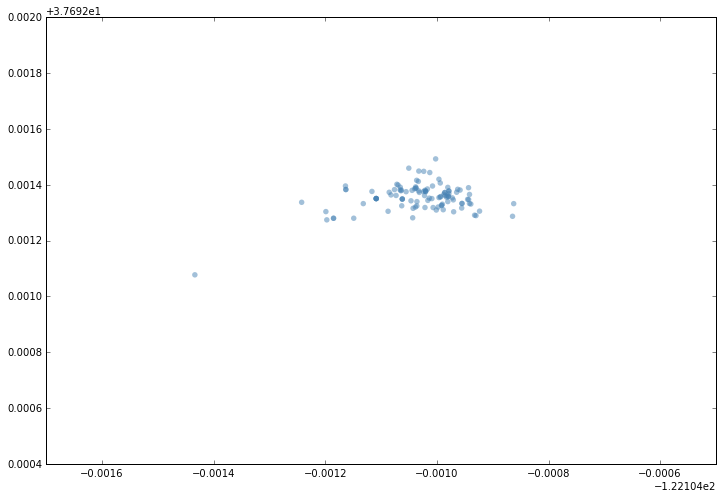

In [28]:
# get colors and plot all the points, color-coded by cluster (or gray if not in any cluster, aka noise)
fig, ax = plt.subplots(figsize=[12,8])
ax.set_xlim([-122.1057, -122.1045])
ax.set_ylim([37.6924,37.694])
#colors = plt.cm.rainbow(np.linspace(0, 1, len(db_labels_unique)))

color = 'steelblue'
db_label = 1600

# for each cluster label and color, plot the cluster's points
#for db_label, color in zip(db_labels_unique, colors):
    
size = 30
#if db_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
#    color = 'gray'
#    size = 3
#    alpha=0.01

# plot the points that match the current cluster label
x_coords = X[db_labels==db_label][:,1]
y_coords = X[db_labels==db_label][:,0]
ax.scatter(x=x_coords, y=y_coords, c=color, edgecolor='', s=size, alpha=0.5)

#ax.set_title('Number of clusters: {}'.format(n_clusters_)) #string concatenation
plt.show()

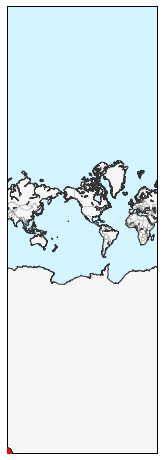

In [43]:
from mpl_toolkits.basemap import Basemap
# define basemap colors
land_color = '#F6F6F6'
water_color = '#D2F5FF'
coastline_color = '#333333'
border_color = '#999999'

plt.figure(figsize=[12, 8]) #make plot the same height:width ratio

m = Basemap(ellps='WGS84', projection='merc', 
            lat_1=37.692, lat_2=37.694, lon_0=-122.1051, lat_0=37.693, 
            width=400, height=200,
            resolution='l', area_thresh=10000)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawmapboundary(fill_color=water_color)

# project and plot our lat-long data
x_coords = X[db_labels==db_label][:,1]
y_coords = X[db_labels==db_label][:,0]
m.scatter(x=x_coords, y=y_coords, s=100, color='r', edgecolor='#333333', alpha=0.4, zorder=10)

Part 2. Clustering: Scalability 

In [ ]:
records = {}
for n in range(100, 100100, 100):
    
    sample = n
    total = len(X)
    subset = X[0::int(total/sample)]
    
    ## initialize with K-means++, a good way of speeding up convergence
    k_means = KMeans(init='k-means++', n_clusters=100, n_init=10)
    ## record the current time
    t_km = time.time()
    # start clustering!
    k_means.fit(subset)
    ## get the time to finish clustering
    t_fin_km = time.time() - t_km
    
    records[sample] = t_fin_km

In [ ]:
records_df = pd.DataFrame.from_dict(records, orient = 'index')
records_df.to_csv('data/part2_1.csv')

In [ ]:
fig, ax = plt.subplots(figsize=[8,10])
ax.scatter(x=list(records.keys()), y=list(records.values()))
#plt.savefig('part2.pdf')

In [ ]:
#K-means....need to rerun
#Number of requested clusters k (consider the range of 2 to the k_max)
k_max = 380
records = {}
for n in range(2, k_max+1):

    ## initialize with K-means++, a good way of speeding up convergence
    k_means = KMeans(init='k-means++', n_clusters=n, n_init=10)
    ## record the current time
    t_km = time.time()
    # start clustering!
    k_means.fit(X)
    ## get the time to finish clustering
    t_fin_km = time.time() - t_km
    
    records[n] = t_fin_km

In [ ]:
records_df = pd.DataFrame.from_dict(records, orient = 'index')
records_df.to_csv('data/part2_1_b_Kmeans.csv')

In [ ]:
fig, ax = plt.subplots(figsize=[8,10])
ax.scatter(x=list(records.keys()), y=list(records.values()))
#plt.savefig('part2_.pdf')

In [ ]:
#mini batch k_means

In [ ]:
records = {}
for n in range(2000, 101000, 1000):
    
    print ('begin ' + str(n))
    sample = n
    total = len(X)
    subset = X[0::int(total/sample)]

    perc=0.0005
    batch_size=int(len(subset)*perc)

    mbk = MiniBatchKMeans(init='k-means++', n_clusters=100, batch_size=batch_size,
                          n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(subset)
    t_mini_batch = time.time() - t0
    
    records[n] = t_mini_batch

In [ ]:
records_df = pd.DataFrame.from_dict(records, orient = 'index')
records_df.to_csv('data/part2_1_a_MiniBatchK_0.0005.csv')

In [ ]:
fig, ax = plt.subplots(figsize=[8,10])
ax.scatter(x=list(records.keys()), y=list(records.values()))
plt.savefig('part2_1_a_minibatch.pdf')

In [ ]:
# minibatch kmeans
#Number of requested clusters k (consider the range of 2 to the k_max)
k_max = 1350
records = {}
for n in range(2, k_max+1, 100):

    perc=0.01
    batch_size=int(len(X)*perc)
    
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n, batch_size=batch_size,
                          n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(X)
    t_mini_batch = time.time() - t0
    
    records[n] = t_mini_batch

In [ ]:
records_df = pd.DataFrame.from_dict(records, orient = 'index')
records_df.to_csv('data/part21MiniBatchKCluster_0.01.csv')

In [ ]:
fig, ax = plt.subplots(figsize=[8,10])
ax.scatter(x=list(records.keys()), y=list(records.values()))
plt.savefig('part2_1_b_minibatch.pdf')

In [ ]:
list(y)

In [ ]:
recordedtime = {}
#ncluster = {}
for n in range(100, 100100, 100):
    eps=0.001
    
    sample = n
    total = len(X)
    subset = X[0::int(total/sample)]
    
    t_db = time.time()
    db = DBSCAN(eps=eps, min_samples=100).fit(subset)
    t_fin_db = time.time() - t_db
    
    recordedtime[n] = t_fin_db

In [ ]:
recordedtime_df = pd.DataFrame.from_dict(recordedtime, orient = 'index')
recordedtime_df.to_csv('data/part2_2.csv')

In [ ]:
fig, ax = plt.subplots(figsize=[8,10])
ax.scatter(x=list(recordedtime.keys()), y=list(recordedtime.values()))
plt.savefig('part2_2.pdf')